In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from fastembed import SparseTextEmbedding
from fastembed.rerank.cross_encoder import TextCrossEncoder
from qdrant_client import QdrantClient
from qdrant_client.models import (
    models,
    Distance, 
    VectorParams, 
    PointStruct,
    CreateCollection,
    FieldCondition,
    MatchValue,
    Filter, Datatype, HnswConfigDiff, SparseVectorParams,
)
import uuid
import tqdm
from datetime import datetime
from typing import List, Dict, Tuple, Optional

# LangChain imports for LLM integration
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import Document
from langchain.chains import LLMChain
from langchain_core.runnables import RunnablePassthrough

/Users/huynhanhkiet/Desktop/Fine-tune-LegalVN/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_core.tools import tool

# @tool
def retrieve_and_rerank(
        query: str, 
        top_k: int = 20, 
        rerank_top_k: int = 10,
        fusion_method: str = "RRF"
    ) -> List[Dict]:
        """
        Perform hybrid retrieval (dense + sparse) followed by reranking.
        
        Args:
            query: The search query
            top_k: Number of documents to retrieve initially
            rerank_top_k: Number of documents to rerank
            fusion_method: Fusion method for combining dense and sparse results ("RRF" for Reciprocal Rank Fusion)
            
        Returns:
            List of dictionaries containing document information and scores
        """
        
        # Generate query embeddings
        dense_vector_query = dense_embedding_model.encode(query)
        bm25_vector_query = sparse_embedding_model.embed(query)
        bm25_query_vector = list(bm25_vector_query)[0]
        
        # Perform hybrid search
        search_result = client.query_points(
            collection_name=collection_name,
            query=models.FusionQuery(
                fusion=models.Fusion.RRF if fusion_method == "RRF" else models.Fusion.DBSF
            ),
            prefetch=[
                models.Prefetch(
                    query=dense_vector_query,
                    using="dense",
                    limit=top_k
                ),
                models.Prefetch(
                    query=bm25_query_vector.as_object(),
                    using="bm25",
                    limit=top_k
                ),
            ],
            with_payload=True,
            with_vectors=True,
            limit=top_k
        ).points
        
        # Extract document texts for reranking
        initial_hits = [hit.payload["raw_context"] for hit in search_result[:rerank_top_k]]
        
        if not initial_hits:
            logger.warning("No documents found for reranking")
            return []
        
        # Perform reranking
        new_scores = list(rerank_model.rerank(query, initial_hits))
        
        # Create ranking with original indices
        ranking = list(enumerate(new_scores))
        ranking.sort(key=lambda x: x[1], reverse=True)
        
        # Prepare results
        results = []
        for rank, (original_idx, rerank_score) in enumerate(ranking, 1):
            original_hit = search_result[original_idx]
            results.append({
                "rank": rank,
                "id": original_hit.id,
                "document": original_hit.payload["raw_context"],
                "rerank_score": rerank_score,
                "original_score": original_hit.score if hasattr(original_hit, 'score') else None,
                "create_at": original_hit.payload.get("create_at", "N/A")
            })
        return results

In [3]:
collection_name = "thue-phi-le-phi_all-MiniLM-L6-v2"

# Initialize Qdrant client
client = QdrantClient(
    host="localhost", 
    port=6333, 
    timeout=600.0
)

In [4]:
# retriever = retrieve_and_rerank_simple(query="Thuế thu nhập cá nhân là gì?",
#                                     top_k=10, rerank_top_k=5)

In [5]:
!ollama list

NAME                       ID              SIZE      MODIFIED     
llama3.1:8b                46e0c10c039e    4.9 GB    8 days ago      
gemma3:1b                  8648f39daa8f    815 MB    11 days ago     
gemma3:270m                e7d36fb2c3b3    291 MB    11 days ago     
nomic-embed-text:latest    0a109f422b47    274 MB    2 months ago    


In [6]:
dense_model_name = "sentence-transformers/all-MiniLM-L6-v2"
sparse_model_name = "Qdrant/bm25"
rerank_model_name = "jinaai/jina-reranker-v2-base-multilingual"
llm_model_name = "llama3.1:8b"

In [7]:
dense_embedding_model = SentenceTransformer(dense_model_name)
sparse_embedding_model = SparseTextEmbedding(sparse_model_name)
rerank_model = TextCrossEncoder(rerank_model_name)

In [8]:
# Initialize LLM for answer generation
llm = ChatOllama(
    model=llm_model_name,
    temperature=0.1,  # Low temperature for more consistent answers
)

In [29]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

# Initialize RAG prompt template
SYSTEM_PROMPT = PromptTemplate.from_template("""Bạn là một trợ lý AI chuyên về pháp luật Việt Nam, đặc biệt là về thuế phí và lệ phí. 
Hãy trả lời câu hỏi của người dùng dựa trên thông tin từ các văn bản pháp luật được truy xuất bên dưới.

Hướng dẫn:
1. Chỉ sử dụng thông tin từ các văn bản được truy xuất
2. Trả lời bằng tiếng Việt một cách rõ ràng và dễ hiểu
4. Luôn trích dẫn nguồn Tài liệu nào được truy xuất liên quan đến câu hỏi
5. Nếu không bạn không biết câu trả lời, hãy nói "Tôi không biết" và nói rõ lý do

Văn bản pháp luật được truy xuất:
{context}

Câu hỏi: {query}

Trả lời:""")

In [20]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # messages: Annotated[List, "The messages in the conversation"]
    query: Annotated[str, "The current user query"]
    retrieved_docs: Annotated[List[Dict], "Retrieved documents from RAG"]
    response: Annotated[str, "The AI response"]

In [21]:
from qdrant_client import QdrantClient, models

def retrieve_and_rerank(state: State):
    
    query = state["query"][-1]
    top_k=20
    rerank_top_k=20
    
    # 1. Encode truy vấn
    dense_q = dense_embedding_model.encode(query)
    bm25_q = sparse_embedding_model.embed(query)
    bm25_qv = list(bm25_q)[0]

    # 2. Truy vấn BM25
    res_sparse = client.query_points(
        collection_name=collection_name,
        query=models.SparseVector(**bm25_qv.as_object()),
        limit=top_k,
        using="bm25",
        with_payload=True
    ).points

    # 3. Truy vấn Dense
    res_dense = client.query_points(
        collection_name=collection_name,
        query=dense_q,
        limit=top_k,
        using="dense",
        with_payload=True
    ).points

    # 4. Gộp candidate (loại trùng)
    candidates = {p.id: p for p in res_sparse + res_dense}

    # 5. Lấy nội dung để rerank
    texts = [p.payload["raw_context"] for p in list(candidates.values())[:rerank_top_k]]

    if not texts:
        return []

    # 6. Reranking
    rerank_scores = rerank_model.rerank(query, texts)

    # 7. Sắp xếp kết quả mới
    ordered = sorted(
        zip(candidates.values(), rerank_scores),
        key=lambda x: x[1],
        reverse=True
    )

    # 8. Chuẩn bị kết quả
    result_retrieved = [
            {
                "id": doc.id,
                "document": doc.payload["raw_context"],
                "rerank_score": score,
                "source": "sparse" if doc in res_sparse else "dense"
            }
            for doc, score in ordered[:rerank_top_k]
        ]
    retrieved_docs = "\n\n".join([f"Tài liệu {i}:\n{doc['document']}\n" 
                                for i, doc in enumerate(result_retrieved, 1)])
    return {"retrieved_docs": result_retrieved}

In [30]:
def generate_answer(state: State):
    query = state["query"][-1]
    retrieved_docs = "\n\n".join([f"Tài liệu {i}:\n{doc['document']}\n" 
                                for i, doc in enumerate(state["retrieved_docs"], 1)])
    messages = SYSTEM_PROMPT.invoke({"query": query, "context": retrieved_docs})
    # print(messages)
    response = llm.invoke(messages)
    
    return {"response": response.content}

# graph_builder.add_node("generate_answer", generate_answer)

In [31]:
# graph_builder.add_edge(START, "generate_answer")
# graph_builder.add_edge("generate_answer", END)
# graph = graph_builder.compile()

graph_builder = StateGraph(State).add_sequence([retrieve_and_rerank, generate_answer])
graph_builder.add_edge(START, "retrieve_and_rerank")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()

In [32]:
# response = graph.invoke({"query": "Đối tượng nào không phải thực hiện quyết toán thuế thu nhập cá nhân?"})
# print(response["response"])

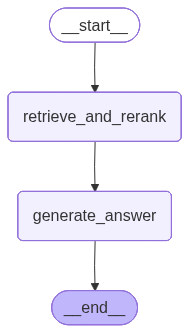

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
retrieve_and_rerank(state={"query":
                "Thời điểm thực hiện khấu trừ, xác định số thuế phải khấu trừ theo Nghị định 117 ra sao?"})

{'retrieved_docs': [{'id': 'ba13bfca-516b-45f1-8f15-18a552d301fb',
   'document': 'Có thế giải thích quyết toán thuế TNCN là việc xác định số tiền thuế thu nhập cá nhân phải nộp của năm tính thuế. Việc này được thực hiện thông qua việc kê khai các khoản thu nhập, các khoản khấu trừ và các khoản thuế đã nộp.',
   'rerank_score': -0.7976019978523254,
   'source': 'dense'},
  {'id': '576161f8-fcf0-409f-90b5-743429a68b12',
   'document': 'Tại Điều 8 Luật Thuế giá trị gia tăng 2024 quy định thời điểm xác định thuế giá trị gia tăng đối với hàng hóa là thời điểm chuyển giao quyền sở hữu hoặc quyền sử dụng hàng hóa cho người mua hoặc thời điểm lập hóa đơn, không phân biệt đã thu được tiền hay chưa thu được tiền. Thời điểm xác định thuế giá trị gia tăng đối với hàng hóa xuất khẩu, hàng hóa nhập khẩu do Chính phủ quy định.',
   'rerank_score': -1.2667887210845947,
   'source': 'dense'},
  {'id': '732f26f0-8885-4857-bd9f-bf24f2e45768',
   'document': 'Dựa vào Điều 17. Căn cứ tính thuế\nCăn cứ tín

In [38]:
inputs = {"query": "Thời điểm thực hiện khấu trừ, xác định số thuế phải khấu trừ theo Nghị định 117 ra sao?"}
for message_chunk, metadata in graph.stream(inputs, stream_mode="messages",):
    if message_chunk.content:
        print(message_chunk.content, end="", flush=True)

Thu nhập tính thuế TNDN được xác định bằng thu nhập chịu thuế trừ thu nhập được miễn thuế và các khoản lỗ được kết chuyển từ các năm trước.

Thu nhập chịu thuế bằng doanh thu trừ các khoản chi được trừ của hoạt động sản xuất, kinh doanh cộng thu nhập khác, kể cả thu nhập nhận được ở ngoài Việt Nam.

Thu nhập từ hoạt động chuyển nhượng bất động sản, chuyển nhượng dự án đầu tư, chuyển nhượng quyền tham gia dự án đầu tư, chuyển nhượng quyền thăm dò, khai thác, chế biến khoáng sản phải xác định riêng để kê khai nộp thuế.